<a href="https://colab.research.google.com/github/mantzaris/teddyCode/blob/main/test_sparce_using_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2022-11-06 19:58:09 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [1]:
import Pkg; Pkg.add("Plots");
import Pkg; Pkg.add("StatsBase");
import Pkg; Pkg.add("InvertedIndices");

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JpegTurbo_jll ──────────────── v2.1.2+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed GR_jll ─────────────────────── v0.69.1+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed LoggingExtras ──────────────── v0.4.9
   Installed Grisu ──────────────────────── v1.0.2
   Installed Measures ───────────────────── v0.3.1
   Installed RelocatableFolders ─────────── v1.0.0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed Formatting ─────────────────── v0.4.2
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed PlotUtils ──────────────────── v1.3.1
   Installed OpenSSL ────────────────────── v1.3.1
   Installed Xorg_

In [2]:
using Random
using InvertedIndices
using SparseArrays
using StatsBase
using LinearAlgebra
using Plots
using BenchmarkTools

In [3]:
#convert adj to S marix
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end


A2S (generic function with 1 method)

In [4]:
#This function prints the zeros and non zero elements of a matrix
#mtrx = the matrix we want to find each zeros and non zeros
function get_zeros_and_non_zeros(mtrx)
  s_0 = 0
  s_n_0 = 0
  for i in range(1, size(mtrx, 1))
    for j in range(1, size(mtrx, 2))
      if mtrx[i,j] == 0
        s_0 = s_0 + 1
      else 
        s_n_0 = s_n_0 + 1
      end
    end
  end
  print("Number of zeros $s_0 and Number of Non zeros $s_n_0")
end

get_zeros_and_non_zeros (generic function with 1 method)

In [5]:
#This function makes a random list of numbers which are gonna be used in the creation of a random sparse matrix
#dn_limit = the down limit of the random range. i.e. the range of the random numbers will be range(dn_limit, up_limit) 
#up_limit = the up limit of the random range. i.e. the range of the random numbers will be range(dn_limit, up_limit) 
#lenght_of_random_list = the length of the random number list we want to create 
#seed_number = the seed number to radomly create the list

function get_random_list(dn_limit, up_limit, length_of_list, seed_number)
    Random.seed!(seed_number)
    a = sample(dn_limit : up_limit, length_of_list, replace = true)
return a
end 

get_random_list (generic function with 1 method)

In [6]:
#-------Do NOT use this-------

#This function creates a random sprce matrix
#row_numbers_list is a random list with the number of rows in which elements will be stored
#column_numbers_list is a random list with the number of columns in which elements will be stored
#sparse_values_list is a list with the values of the sparse matrix.
#sparse_dim = the dimention of the sparse matrix and has to be greater that the up_limit defined in the get_random_list_NO_repeat function defined on the above
function get_random_sparse_matrix(row_numbers_list, column_numbers_list, sparse_values_list, sparse_dim)
    append!(row_numbers_list, sparse_dim)
    append!(column_numbers_list, sparse_dim)
    append!(sparse_values_list, sparse_dim)
    A = sparse(row_numbers_list, column_numbers_list, sparse_values_list)
    return(A)
end 

get_random_sparse_matrix (generic function with 1 method)

In [7]:
#This function returns the dimention and the  memory of a sparse matrix:
#from = the initial dimention of sparse matrix
#to = final dimention of sparce matrix
#step = the step to create sparce matrices
#dn_limit = the down limit of the randomly created list which will be used to create the row, columns and sparse matrix values. i.e. the range of the random numbers will be range(dn_limit, up_limit) 
#up_limit = the up limit of the randomly created list which will be used to create the row, columns and sparse matrix values. i.e. the range of the random numbers will be range(dn_limit, up_limit) 
#lenght_of_random_list = the length of the random number list we want to create 
#seed_1, seed_2, seed_3 = the numbers to crate different random lists which will be assigned as row_num, col_num, sparse_vals

function get_memory(from, to, step, dn_limit, up_limit, length_of_list, seed_1, seed_2, seed_3)
  benchmarkDicts = Dict()
  benchmarkDicts["memory"] = []
  i_list = []
  for i in from:step:to
    row_num = get_random_list(dn_limit, up_limit, length_of_list, seed_1)
    col_num = get_random_list(dn_limit, up_limit, length_of_list, seed_2)
    sparse_vals = get_random_list(dn_limit, up_limit, length_of_list, seed_3)
    #sparse_dimention has to be more than up_range, which means that i has to be greater than from value in the for loop. 
    #This is happening because the sparse matrix will have dimention the max element of (row_num, col_num). To be sure for the dimention of sprse matrix I chose this constrain
    mem = @benchmark get_random_sparse_matrix($row_num, $col_num, $sparse_vals, $i);
    push!(benchmarkDicts["memory"], mem.memory/10^6)
    append!(i_list, i)
  end
  return(i_list, benchmarkDicts["memory"])
end

get_memory (generic function with 1 method)

In [8]:
#Numbers can be repeated in the created random lists
#This function makes a random sparse matrix
#dn_limit = the down limit of the randomly created row_index list, column_index_list, values_list range. i.e. the range of the random numbers in the lists will be: range(dn_limit, up_limit) 
#seed_1, seed_2, seed_3 = the seed number to radomly create the lists(row_index, column_index, values) respectively
#x_dim =  rows of sparce matrix
#y_dim = columns of sparce matrix 
#NOTE : x_dim AND y_dim have to be greater than up_limit
#If they are not: Example: sparse : (20 x 10) and up_limit = 100 (assuming that it is in up_limit or dn_limit list)  the function will look for
# element sp[100, j] in order to asing a value. This element does not exist

function make_random_sparse(x_dim, y_dim, dn_limit, seed_1, seed_2, seed_3)
  #up_limit: less than sparse_x AND sparse_y
  #up_limit = dn_lim + 100
  up_limit = min(x_dim, y_dim) - 1;
  #non_zero_length_list: a number so that most of the elements of the marix are zero. The limit is: number_of_zeros = number_of_non_zeros + 1
  non_zero_length_list = floor(Int, x_dim*y_dim/2 -1)
  row_index = get_random_list(dn_limit, up_limit, non_zero_length_list, seed_1);
  column_index = get_random_list(dn_limit, up_limit, non_zero_length_list, seed_2);
  values = get_random_list(dn_limit, up_limit, non_zero_length_list, seed_3);
  sp = spzeros(x_dim ,y_dim)
  for i in range(1, length(row_index))
    sp[row_index[i], column_index[i]] = values[i]
  end
  return(sp)
end 

make_random_sparse (generic function with 1 method)

In [9]:
#This function creates the ajsparse matrix, converts it to s matrix, makes random theta matrix, makes random x matrix. All the random are using seed. No sparce matrix
#It multiplies s * x * th and returns a, s, x, th, the Final = s * x * th  
#aj_x_dim = aj matrix rows
#aj_y_dim = aj matrix columns
#dn_limit = the down limit of the randomly created row_index list, column_index_list, values_list range. i.e. the range of the random numbers in the lists will be: range(dn_limit, up_limit) 
#x_y_dim = the number of columns of x matrix
#th_y_dim = the number of columns of th_matrix
#returns the s * x * th 


function initial_matrix(aj_x_dim, aj_y_dim, dn_limit, x_y_dim, th_y_dim, seed_1, seed_2, seed_3)
  aj = make_random_sparse(aj_x_dim, aj_y_dim, dn_limit, seed_1, seed_2, seed_3)
  s = A2S(aj)
  x = make_random_sparse(aj_y_dim, x_y_dim, dn_limit, seed_1, seed_2, seed_3)
  th = make_random_sparse(x_y_dim, th_y_dim, dn_limit, seed_1, seed_2, seed_3)
  final = s * x * th 
  return aj, s, x, th, final
end

initial_matrix (generic function with 1 method)

In [10]:
#get the mean average error of two matrices, the one of them is reduced
#mtrx = the NOT reduced matrix
#mtrx_reduced = the reduced matrix
#The function returns the mean average error of tow matrices

function mae(mtrx, mtrx_reduced)
  x = size(mtrx_reduced, 1)
  y = size(mtrx_reduced, 2)
  s = 0
  for i in range(1, x)
    for j in range(1, y)
      s = s + abs(mtrx[i, j] - mtrx_reduced[i, j])
    end
  end
  mae = sqrt(s/(x*y))
  return mae 
  end

mae (generic function with 1 method)

In [11]:
#This function reduces the size of a matrix by throughing the last n_col_row_to_reduce rows-columns
#aj = aj matrix
#x = x_matrix 
#th = th_matrix
#n_col_row_to_reduce = how many rows-columns we want to drop

function reduce_size(aj, x, th, n_col_row_to_reduce)
  x_dim = size(aj, 1)
  y_dim = size(aj, 2)
  aj_reduced = aj[Not(x_dim - n_col_row_to_reduce: end), Not(y_dim - n_col_row_to_reduce : end)]
  s_reduced = A2S(aj_reduced)
  x_reduced = x[Not(x_dim - n_col_row_to_reduce: end), :]
  Final_reduced = s_reduced * x_reduced * th
  return Final_reduced
  end


reduce_size (generic function with 1 method)

In [12]:
#This function makes the aj, s, x, th. Then reduces the size of aj and gets the mean average error between the initial s*x*th and s_reduced*x*th and
#n_drop_row_col = how many rows-columns we want to drop
#a_dim = a_matrix dimention, note that _mtrix is a square matrix, so number_of_rows = number_of_columns
#a_down_lim = a_mtrix till be filled in a random range(k, l), a_down_lim = k
#a_up_lim = a_mtrix till be filled in a random range(k, l), a_down_lim = l
#x_y_dim = the number of columns of x matrix
#x_down_lim = x_matrix will be filled in a random range(b, c), x_down_lim = b
#x_up_lim = x_matrix will be filled in a random range(b, c), x_up_lim = c
#th_y_dim = the number of columns of th_matrix
#th_down_lim = x_matrix will be filled in a random range(d, e), x_down_lim = d
#th_up_lim = x_matrix will be filled in a random range(d, e), x_up_lim = e
function total_error(n_drop_row_col, aj_x_dim, aj_y_dim, dn_limit, x_y_dim, th_y_dim, seed_1, seed_2, seed_3)
  mean_average_error = Vector{Float64}()
  aj, s, x, th, Final = initial_matrix(aj_x_dim, aj_y_dim, dn_limit, x_y_dim, th_y_dim, seed_1, seed_2, seed_3)
  for i in range(0, n_drop_row_col)
    F1 = reduce_size(aj, x, th, i)
    MAE = mae(Final, F1)
    append!(mean_average_error,MAE)
  end
  skip = collect(0: n_drop_row_col)
  return(mean_average_error, skip)
  end

total_error (generic function with 1 method)

In [13]:
#This function splits the alpha(aj) matrix in smaller matrices which size is (n_lines_to_split x n_lines_to_split). 
 #a_mtrx = the a_matrix
 #n_lines_to_split is the number of rows, columns the small matrix will have.
 #The function returns a dictionary. Each element of the dictionary is one of the smaller matrices.

 function split_aj_matrix(a_mtrx, n_lines_to_split)
  x = size(a_mtrx, 1)
  y = size(a_mtrx, 2)
  n = div(x, n_lines_to_split)
  dictionary = Dict()
  count = 1
  k = 1
  for i in range(1, n_lines_to_split)
    z = 1
    for j in range(1, n_lines_to_split)
      dictionary["a_$count"] = a_mtrx[k: k + n - 1, z: j*n ]
      count = count + 1
      z = z + n
    end
    k = k + n
  end
  return(dictionary)
end


split_aj_matrix (generic function with 1 method)

In [14]:
#This function splits the x matrix in smaller matrices which size is (n_lines_to_split x n_lines_to_split). 
 #a_mtrx = the a_matrix
 #n_lines_to_split is the number of rows, columns the small matrix will have.
 #The function returns a dictionary. Each element of the dictionary is one of the smaller matrices.
  
  function split_x_matrix(x_mtrx, n_lines_to_split)
  x = size(x_mtrx, 1)
  n = div(x, n_lines_to_split)
  #print(n)
  dictionary = Dict()
  z = 1
  for i in range(1, n_lines_to_split)
    dictionary["x_$i"] = x_mtrx[z : z + n - 1 , 1:end]
    z = z + n
  end
  return(dictionary)
  end


split_x_matrix (generic function with 1 method)

In [15]:
#This matrix turns s_matrix*x_matrix (in dictionary form), to matrix
#dict = the dictionary we want to conver to matrix
#x_mtrx = x_matrix
#n_lines_to_split =  is the number of rows, columns the small matrix will have.
#It returns the s_matrix*x_matrix in a matrix form

function s_matrix_x_xmtrx_dictionary_to_matrix(dict, x_splited_length, x_mtrx, n_lines_to_split)
  i = 1 
  mtrx_reduced_dictionary = Dict()
  count = 1
  num = div(size(x_mtrx, 1), n_lines_to_split)
  while (i <= length(dict)) 
    x_y_dim = size(x_mtrx, 2)
    s = zeros(num, x_y_dim)
    k = 1 
    while k <= x_splited_length  
      s = s + dict["aj_x_$i"] 
      k = k + 1 
      i = i + 1
    end 
  mtrx_reduced_dictionary["A_$count"] = s
  count = count + 1
  end 
  s_ = vcat(mtrx_reduced_dictionary["A_1"])
  for i in range(2, length(mtrx_reduced_dictionary))
    aux = vcat(s_, mtrx_reduced_dictionary["A_$i"])
    s_ = aux
  end
  return s_ 
end


s_matrix_x_xmtrx_dictionary_to_matrix (generic function with 1 method)

In [16]:
#This function reads a_matrix, x_matrix, th_matrix, and the number of rows, columns the splited matrices will have.
#a_mmtrx = a_matrix
#x_mtrx = x_matrix
#th_mtrx = th_matrix
#n_lines_to_split = number of rows, columns the small matrices will have
#it splits a_matrix, x_matrix into smaller matrices by saving the in dictionaries and also find s matrix for the splited a_matrix
#then it calculates the s_splited*x_splited, saves it in dictionary and then makes it matrix
#It calculates the s_splited*x_splite[as a matrix])*th_matrix
#It returns the s_splited*x_splite*th_matrix as a matrix

function multiply_splited_2(a_mtrx, x_mtrx, th_mtrx, n_lines_to_split)
  a_splited = split_aj_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  #x_y_dim = size(x_mtrx, 2)
  aj_splited = Dict()
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = s_matrix_x_xmtrx_dictionary_to_matrix(aj_x, length(x_splited), x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end

multiply_splited_2 (generic function with 1 method)

In [17]:
#This function get the mean average error of splitted matrices 
#aj = adjacency matrix
#x = x_matrix
#th = thema_matrix
#n_lines_to_split =  is the number of rows, columns the small matrix will have.
function mae_splited(aj, x, th, final, n_lines_to_split)
  mae_splited = Vector{Float64}()
  counter = Vector{Float64}()
  for i in range(1, n_lines_to_split)
    f = multiply_splited_2(aj, x, th, i);
    mae_spl = mae(final, f);
    append!(mae_splited, mae_spl)
    append!(counter, i)
    end
  return(mae_splited, counter)
end

mae_splited (generic function with 1 method)

In [18]:
#This function gets the memory of many matrices, filled randomly. The matrices are filled without using seed.
#0, 150 is the range of the matrix. The matrix is filled in the range (0, 150)
#from = the size of the first matrix
#to = the size of the last matrix
#step = the step the matrices are created
#For example: the first random matrix is (100 x 100), the next will be ((100 + step) x (100 + step)) ...
#dn_limit = the down limit of the randomly created list which will be used to create the row, columns and sparse matrix values. i.e. the range of the random numbers will be range(dn_limit, up_limit) 
#seed_1, seed_2, seed_3 = the numbers to crate different random lists which will be assigned as row_num, col_num, sparse_vals


function get_memory_to_fill_random_matrix(from, step, to, dn_limit, seed_1, seed_2, seed_3)
benchmarkDicts = Dict()
benchmarkDicts["memory"] = []
i_list = []
for i in from:step:to
  mem = @benchmark make_random_sparse($i, $i, dn_limit, seed_1, seed_2, seed_3);
  push!(benchmarkDicts["memory"], mem.memory/10^6)
  append!(i_list, i)
end
return i_list, benchmarkDicts["memory"]
end

get_memory_to_fill_random_matrix (generic function with 1 method)

In [19]:
#This function says if a number is even or oddd
#number = the number we want to check

function even_odd(number)
  if number%2 == 0
    r = "even"
  else  
    r = "odd"
  end
  return r 
end


even_odd (generic function with 1 method)

In [20]:
#This function gets a radom number list
#length_list = the legth of the lsit
#dn_limit = the downlimit of the list
#up_limit = the up limit of the list
#seed_number = the seed number to be used
 
function get_random_number_list(list_length, dn_limit, up_limit, seed_number)
  l = Vector{Int64}()
  for i in range(1, list_length)
    seed_number += 1
    Random.seed!(seed_number)
    append!(l, rand((dn_limit : up_limit)))
  end
  return l
  end

get_random_number_list (generic function with 1 method)

In [49]:
#Numbers can be repeated in the created random lists
#This function makes a random sparse matrix
#dn_limit = the down limit of the randomly created row_index list, column_index_list, values_list range. i.e. the range of the random numbers in the lists will be: range(dn_limit, up_limit) 
#up_limit = the up limit of the randomly created row_index list, column_index_list, values_list range. i.e. the range of the random numbers in the lists will be: range(dn_limit, up_limit) 
#seed_number = the seed number to be used
#x_dim =  rows of sparce matrix
#NOTE : x_dim AND y_dim have to be greater than up_limit
#If they are not: Example: sparse : (20 x 10) and up_limit = 100 (assuming that it is in up_limit or dn_limit list)  the function will look for
# element sp[100, j] in order to asing a value. This element does not exist

function make_random_sparce_matrix(x_dim, y_dim, dn_limit, up_limit, seed_number)
  number = even_odd(x_dim * y_dim)
  elements = x_dim * y_dim
  if number == "even"
    length_of_non_zero_list =  elements/2 - 1
  else
    length_of_non_zero_list = (elements - 1)/2
  end 
  row_index = get_random_number_list(length_of_non_zero_list, dn_limit, x_dim, seed_number + 1);
  col_index = get_random_number_list(length_of_non_zero_list, dn_limit, y_dim, seed_number + 2);
  values = get_random_number_list(length_of_non_zero_list, dn_limit, up_limit, seed_number);
  sp = spzeros(x_dim ,y_dim)
  for i in range(1, length(values))
    sp[row_index[i] , col_index[i]] = values[i]
  end
  return(sp)
end 

make_random_sparce_matrix (generic function with 1 method)

In [61]:
#This function creates a random matrix by multyplying two random matrices
#0, 150 is the range of the matrix. The matrix is filled in the range (0, 150)
#a_dim = is the dimention of the initial SQUARE matrix we will use to produce a final matrix
#final_dim = the dimention of the final matrix we want to make
#The function returns the final matrix
#Plese use numbers such that final_dim/a_dim = integer, so everything is included

function create_adj_matrix_by_multiply(final_dim, x_dim, y_dim, dn_limit, up_limit, seed_number)
  a_test = make_random_sparce_matrix(x_dim, y_dim, dn_limit, up_limit, seed_number)
  a_f_row = a_test
  a_f_col = a_test
  seed_number += 1
  for i in range(1, final_dim/x_dim -1)
    a_f_row = vcat(a_f_row, make_random_sparce_matrix(x_dim, y_dim, dn_limit, up_limit, seed_number));
    seed_number += 1
  end
  for i in range(1, final_dim/x_dim -1)
    a_f_col = hcat(a_f_col, make_random_sparce_matrix(x_dim, y_dim, dn_limit, up_limit, seed_number));
    seed_number += 1
  end
  ff = a_f_row * a_f_col
  return(ff)
  end


create_adj_matrix_by_multiply (generic function with 1 method)

In [22]:
rows_col_to_skip = 200
x_dim = 1000
y_dim = 1000
dn_lim = 1
x_cols = 10
th_cols = 5
seed_1 = 1
seed_2 = 2
seed_3 = 3

3

In [23]:
error_, skip_  = total_error(rows_col_to_skip, x_dim, y_dim, dn_lim, x_cols, th_cols, seed_1, seed_2, seed_3);

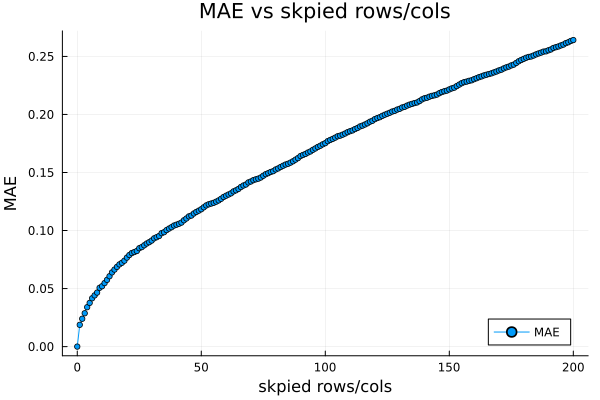

In [24]:
plot(skip_, # x-axis
    error_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs skpied rows/cols",
    xlabel = "skpied rows/cols",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [25]:
aj_dim = 1000;
dn_limit = 1;
x_columns = 20;
th_columns = 5;
seed_1 = 1;
seed_2 = 2;
seed_3 = 3;

In [26]:
aj, s, x, th, final = initial_matrix(aj_dim, aj_dim, dn_limit, x_columns, th_columns, seed_1, seed_2, seed_3);

In [27]:
n_lines_to_split = 100;

In [28]:
mae_splited_, counter_list_ = mae_splited(aj, x, th, final, n_lines_to_split);

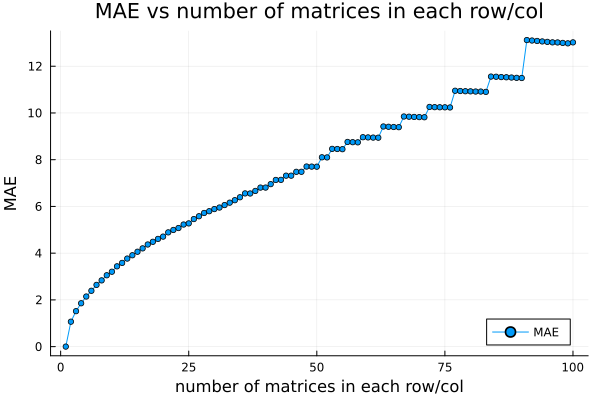

In [29]:
plot(counter_list_, # x-axis
    mae_splited_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs number of matrices in each row/col",
    xlabel = "number of matrices in each row/col",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")


In [88]:
from = 100;
to = 1000;
step = 100;
dn_limit = 1;
seed_1 = 1;
seed_2 = 2;
seed_3 = 3;

In [89]:
count_, mem_ = get_memory_to_fill_random_matrix(from, step, to, dn_lim, seed_1, seed_2, seed_3)

(Any[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], Any[0.232912, 1.15216, 2.748496, 5.757776, 6.838544, 10.527616, 12.088384, 13.889216, 20.691344, 22.972176])

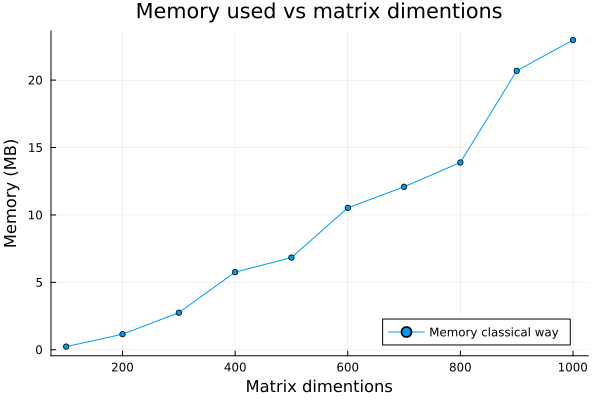

In [78]:
plot(count_, # x-axis
    mem_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Memory classical way",
    legend=:bottomright,
    ylabel = "Memory (MB)")



In [81]:
function get_memory_to_create_adj_matrix_by_multiply(from, step, to, x_dim, y_dim, dn_limit, up_limit, seed_number)
  benchmarkDicts = Dict()
  benchmarkDicts["memory"] = []
  i_list = []
  for i in from:step:to
     mem = @benchmark create_adj_matrix_by_multiply($i, $x_dim, $y_dim, $dn_limit, $up_limit, $seed_number);
    push!(benchmarkDicts["memory"], mem.memory/10^6)
    append!(i_list, i)
  end
  return benchmarkDicts["memory"], i_list
  end

get_memory_to_create_adj_matrix_by_multiply (generic function with 3 methods)

In [90]:
from = 100;
to = 1000;
step = 100;
dn_limit = 1;
seed_number = 1;
x_dim = 1
y_dim = 1
up_limit = 10

10

In [91]:
mem_1, i_list_1 = get_memory_to_create_adj_matrix_by_multiply(from, step, to, x_dim, y_dim, dn_limit, up_limit, seed_number)

(Any[0.267392, 0.703296, 1.307216, 2.072016, 2.997024, 4.081792, 5.326864, 6.731616, 8.296656, 10.021408], Any[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

In [95]:
from = 100;
to = 1000;
step = 100;
dn_limit = 1;
seed_number = 1;
x_dim = 5
y_dim = 5
up_limit = 10

10

In [96]:
mem_5, i_list_5 = get_memory_to_create_adj_matrix_by_multiply(from, step, to, x_dim, y_dim, dn_limit, up_limit, seed_number)

(Any[0.938144, 2.232192, 3.87352, 5.871056, 8.245536, 10.923296, 13.90024, 17.29328, 21.01512, 25.22], Any[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

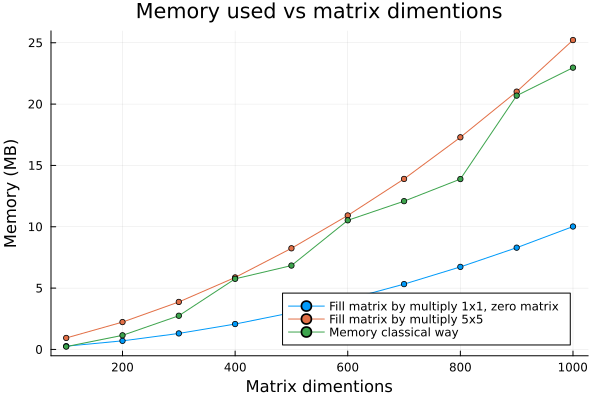

In [99]:
plot(i_list_1, # x-axis
    mem_1, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Fill matrix by multiply 1x1, zero matrix",
    legend=:bottomright,
    ylabel = "Memory (MB)")


plot!(i_list_5, # x-axis
    mem_5, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Fill matrix by multiply 5x5",
    legend=:bottomright,
    ylabel = "Memory (MB)")



plot!(count_, # x-axis
    mem_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Memory classical way",
    legend=:bottomright,
    ylabel = "Memory (MB)")

